# Import dependencies

In [15]:
import pandas as pd
from io import StringIO
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import ezkl
import torch
import torch.nn as nn
import torch.optim as optim
import os
from scipy import stats
import scipy
import onnxruntime
from dataclasses import dataclass
from typing import List, Dict


# Load Data

## Hype Prices

**PLEASE AVOID SPAMMING THIS LINE OTHERWISE WE GET RATE LIMITED**

In [16]:
url = "https://api.coingecko.com/api/v3/coins/hyperliquid/market_chart?vs_currency=usd&days=365&interval=daily"

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-36bsacjiQd1F8rmk5z4j1tMs"
}

response = requests.get(url, headers=headers)

print(response.text)

{"prices":[[1732838400000,6.512709126014327],[1732924800000,6.512709126014327],[1733011200000,8.644603573199845],[1733097600000,9.459223086748034],[1733184000000,8.43020480298621],[1733270400000,11.16858001247626],[1733356800000,10.927396907589728],[1733443200000,12.59259618742528],[1733529600000,13.824764093589229],[1733616000000,14.148295136918554],[1733702400000,14.188638965497068],[1733788800000,13.390810695266785],[1733875200000,13.878510532121165],[1733961600000,16.160291494319157],[1734048000000,18.32086197907653],[1734134400000,19.445355374548534],[1734220800000,24.278950866911032],[1734307200000,24.06784264061239],[1734393600000,27.451297316399142],[1734480000000,25.590526995880662],[1734566400000,23.166825060814343],[1734652800000,25.041541157512242],[1734739200000,29.960485436304847],[1734825600000,32.40674492071673],[1734912000000,28.218793897378536],[1734998400000,28.312352202537458],[1735084800000,29.823925491530062],[1735171200000,26.788314746069965],[1735257600000,26.86

In [17]:
price_json = json.loads(response.text)
prices = price_json["prices"]
prices_df = pd.DataFrame(prices)
prices_df[0] = pd.to_datetime(prices_df[0], unit='ms')

prices_df.columns = ['t', 'c']

# sort
prices_df = prices_df.sort_values('t')

# calculate pct return and log returns
prices_df['pct_returns'] = prices_df['c'].pct_change()
prices_df['log_returns'] = np.log(prices_df['c'] / prices_df['c'].shift(1))

# Remove the first row as it will have NaN for returns
prices_df = prices_df.dropna()

# Display the first few rows of the modified DataFrame
print(prices_df.head())

# Display basic statistics of both types of returns
print("\nPercentage Returns Statistics:")
print(prices_df['pct_returns'].describe())

print("\nLog Returns Statistics:")
print(prices_df['log_returns'].describe())

           t          c  pct_returns  log_returns
1 2024-11-30   6.512709     0.000000     0.000000
2 2024-12-01   8.644604     0.327344     0.283180
3 2024-12-02   9.459223     0.094234     0.090055
4 2024-12-03   8.430205    -0.108785    -0.115169
5 2024-12-04  11.168580     0.324829     0.281283

Percentage Returns Statistics:
count    67.000000
mean      0.023084
std       0.097685
min      -0.129231
25%      -0.046812
50%       0.015005
75%       0.068673
max       0.327344
Name: pct_returns, dtype: float64

Log Returns Statistics:
count    67.000000
mean      0.018535
std       0.092317
min      -0.138378
25%      -0.047943
50%       0.014894
75%       0.066395
max       0.283180
Name: log_returns, dtype: float64


# GARCH model

more details
https://www.investopedia.com/terms/g/generalalizedautogregressiveconditionalheteroskedasticity.asp#:~:text=The%20generalized%20autoregressive%20conditional%20heteroskedasticity,estimate%20volatility%20in%20financial%20markets.

In [18]:
def garch_model(returns, omega, alpha, beta, n_forecast=1):
    """
    Calculate the GARCH model and forecast future volatility.

    Parameters:
    returns (array-like): Historical returns series
    omega (float): The constant term in the GARCH model
    alpha (float): The coefficient for the squared error term
    beta (float): The coefficient for the lagged conditional variance
    n_forecast (int): Number of periods to forecast (default is 1)

    Returns:
    tuple: (conditional_variances, volatility_forecast)
    """
    returns = np.array(returns)
    T = len(returns)

    # Initialize conditional variance array
    conditional_variances = np.zeros(T)

    # Set initial variance to the sample variance
    conditional_variances[0] = np.var(returns)

    # Calculate conditional variances
    for t in range(1, T):
        conditional_variances[t] = (omega +
                                    alpha * returns[t-1]**2 +
                                    beta * conditional_variances[t-1])

    # Forecast future volatility
    last_var = conditional_variances[-1]
    volatility_forecast = np.zeros(n_forecast)
    for i in range(n_forecast):
        next_var = omega + alpha * returns[-1]**2 + beta * last_var
        volatility_forecast[i] = np.sqrt(next_var)
        last_var = next_var

    return conditional_variances, volatility_forecast


In [5]:
# Set GARCH parameters
omega, alpha, beta = 0.0073524998, 0.2663061917, 0.0000010000
n_forecast = 5

# Calculate GARCH for percentage returns
pct_cond_var, pct_forecast = garch_model(prices_df['pct_returns'].values, omega, alpha, beta, n_forecast)

# Calculate GARCH for log returns
log_cond_var, log_forecast = garch_model(prices_df['log_returns'].values, omega, alpha, beta, n_forecast)

# Add percentage and log conditional variances to the DataFrame
prices_df['pct_cond_var'] = pct_cond_var
prices_df['log_cond_var'] = log_cond_var

# Print summary statistics
print("Percentage Returns GARCH Summary:")
print(prices_df['pct_cond_var'].describe())
print("\nLog Returns GARCH Summary:")
print(prices_df['log_cond_var'].describe())

print("\nPercentage Returns Volatility Forecast:")
print(np.sqrt(pct_forecast))
print("\nLog Returns Volatility Forecast:")
print(np.sqrt(log_forecast))

# Calculate correlation between the two volatility series
volatility_correlation = prices_df['pct_cond_var'].corr(prices_df['log_cond_var'])
print(f"\nCorrelation between percentage and log returns volatility: {volatility_correlation:.6f}")

Percentage Returns GARCH Summary:
count    67.000000
mean      0.010027
std       0.005296
min       0.007353
25%       0.007527
50%       0.008356
75%       0.010007
max       0.035888
Name: pct_cond_var, dtype: float64

Log Returns GARCH Summary:
count    67.000000
mean      0.009694
std       0.004070
min       0.007353
25%       0.007527
50%       0.008297
75%       0.010205
max       0.028708
Name: log_cond_var, dtype: float64

Percentage Returns Volatility Forecast:
[0.29663375 0.29663375 0.29663375 0.29663375 0.29663375]

Log Returns Volatility Forecast:
[0.29649555 0.29649554 0.29649554 0.29649554 0.29649554]

Correlation between percentage and log returns volatility: 0.994789


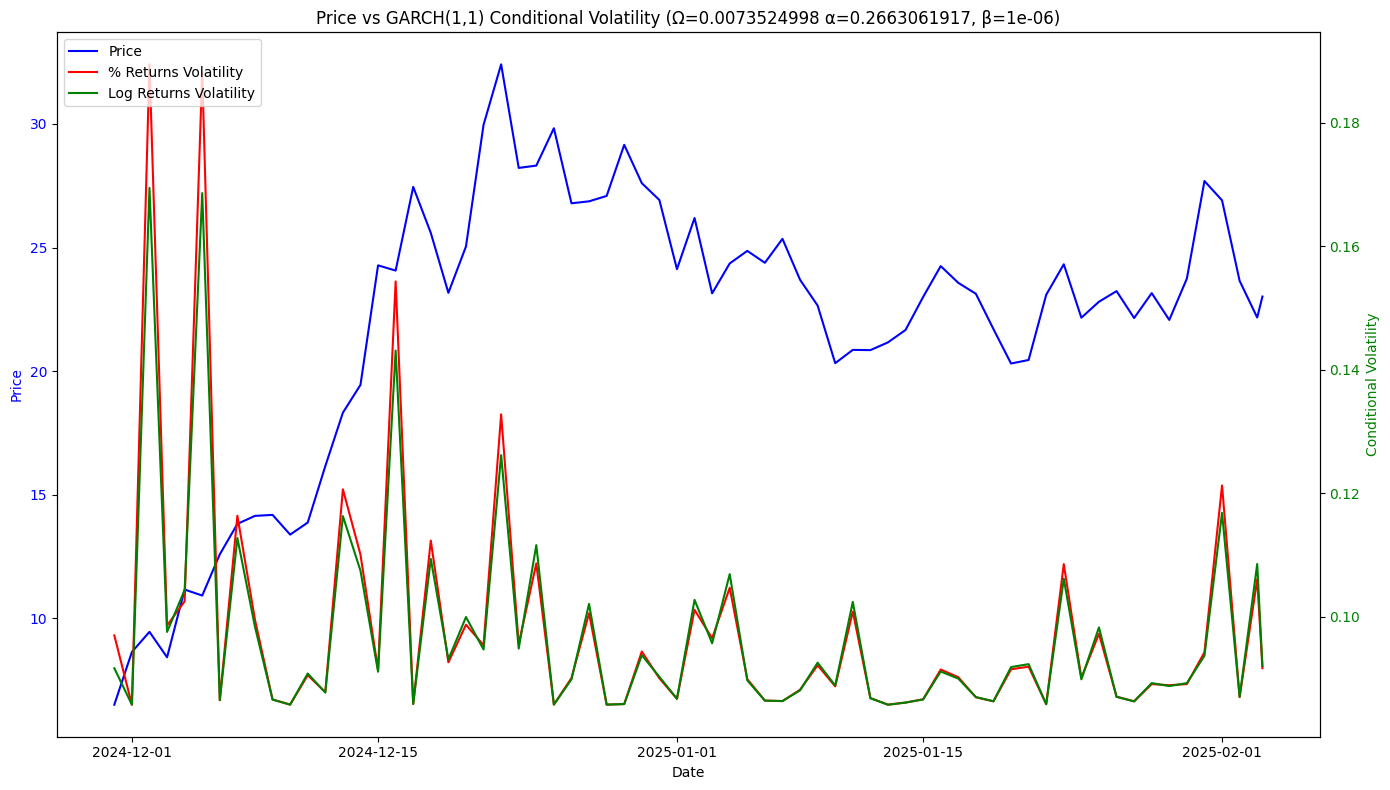

Price Statistics:
count    67.000000
mean     21.851447
std       5.741727
min       6.512709
25%      20.387966
50%      23.146733
75%      25.196461
max      32.406745
Name: c, dtype: float64

Percentage Returns Volatility Statistics:
count    67.000000
mean      0.098094
std       0.020269
min       0.085747
25%       0.086759
50%       0.091410
75%       0.100033
max       0.189442
Name: pct_cond_var, dtype: float64

Log Returns Volatility Statistics:
count    67.000000
mean      0.097034
std       0.016818
min       0.085747
25%       0.086757
50%       0.091090
75%       0.101015
max       0.169434
Name: log_cond_var, dtype: float64

Correlation between Price and % Returns Volatility: -0.2328
Correlation between Price and Log Returns Volatility: -0.2042
Correlation between % and Log Returns Volatility: 0.9947


In [6]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the price on the primary y-axis
ax1.plot(prices_df['t'], prices_df['c'], color='blue', label='Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for volatility
ax2 = ax1.twinx()

# Plot the GARCH volatility estimates on the secondary y-axis
ax2.plot(prices_df['t'], np.sqrt(prices_df['pct_cond_var']), color='red', label='% Returns Volatility')
ax2.plot(prices_df['t'], np.sqrt(prices_df['log_cond_var']), color='green', label='Log Returns Volatility')
ax2.set_ylabel('Conditional Volatility', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f'Price vs GARCH(1,1) Conditional Volatility (Ω={omega} α={alpha}, β={beta})')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print some summary statistics
print("Price Statistics:")
print(prices_df['c'].describe())
print("\nPercentage Returns Volatility Statistics:")
print(np.sqrt(prices_df['pct_cond_var']).describe())
print("\nLog Returns Volatility Statistics:")
print(np.sqrt(prices_df['log_cond_var']).describe())

# Calculate correlations
corr_price_pct_vol = prices_df['c'].corr(np.sqrt(prices_df['pct_cond_var']))
corr_price_log_vol = prices_df['c'].corr(np.sqrt(prices_df['log_cond_var']))
corr_pct_log_vol = np.sqrt(prices_df['pct_cond_var']).corr(np.sqrt(prices_df['log_cond_var']))

print(f"\nCorrelation between Price and % Returns Volatility: {corr_price_pct_vol:.4f}")
print(f"Correlation between Price and Log Returns Volatility: {corr_price_log_vol:.4f}")
print(f"Correlation between % and Log Returns Volatility: {corr_pct_log_vol:.4f}")

Percentage Returns Downside GARCH Summary:
count    66.000000
mean      0.006594
std       0.001502
min       0.004420
25%       0.005293
50%       0.006395
75%       0.007784
max       0.009537
Name: pct_cond_var, dtype: float64

Log Returns Downside GARCH Summary:
count    66.000000
mean      0.006232
std       0.001209
min       0.004413
25%       0.005187
50%       0.006109
75%       0.007210
max       0.008522
Name: log_cond_var, dtype: float64

Percentage Returns Volatility Forecast:
[0.06612906 0.06577502 0.06542413 0.06507638 0.06473174]

Log Returns Volatility Forecast:
[0.06610256 0.06577771 0.06545477 0.06513374 0.0648146 ]

Correlation between percentage and log returns volatility: 0.999579


/Users/ethancemer/Documents/development/sentiment-ezkl-sim/.venv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


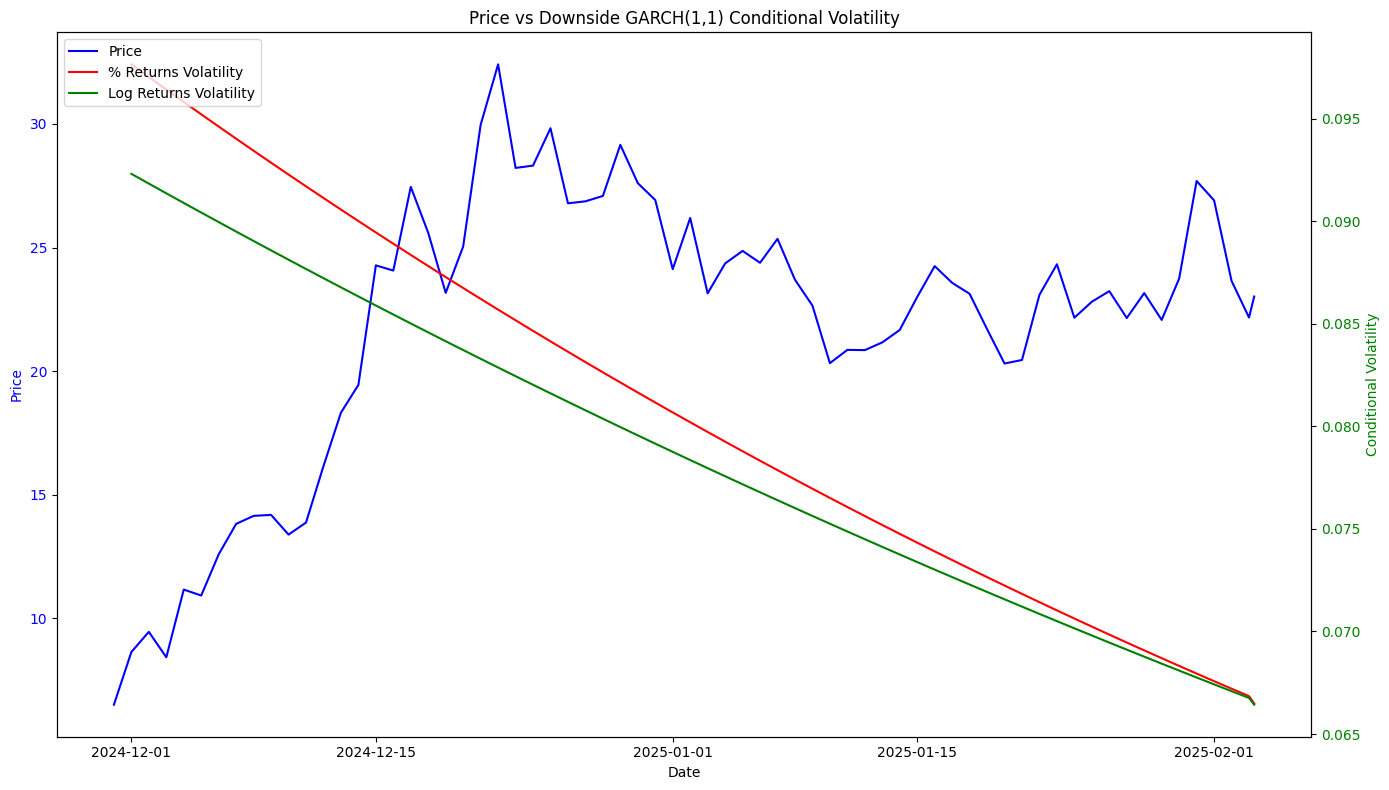

Price Statistics:
count    67.000000
mean     21.851447
std       5.741727
min       6.512709
25%      20.387966
50%      23.146733
75%      25.196461
max      32.406745
Name: c, dtype: float64

Percentage Returns Volatility Statistics:
count    66.000000
mean      0.080688
std       0.009194
min       0.066486
25%       0.072755
50%       0.079966
75%       0.088226
max       0.097656
Name: pct_cond_var, dtype: float64

Log Returns Volatility Statistics:
count    66.000000
mean      0.078578
std       0.007639
min       0.066429
25%       0.072018
50%       0.078163
75%       0.084911
max       0.092316
Name: log_cond_var, dtype: float64

Correlation between Price and % Returns Volatility: -0.5045
Correlation between Price and Log Returns Volatility: -0.4913
Correlation between % and Log Returns Volatility: 0.9998


In [7]:
class DownsideGARCH:
    def __init__(self, returns):
        self.returns = returns
        self.params = None

    def negative_log_likelihood(self, params):
        omega, alpha, beta = params
        T = len(self.returns)
        sigma2 = np.zeros(T)
        sigma2[0] = np.var(self.returns)

        for t in range(1, T):
            sigma2[t] = omega + alpha * max(0, -self.returns[t-1])**2 + beta * sigma2[t-1]

        LL = -0.5 * np.sum(np.log(sigma2) + self.returns**2 / sigma2)
        return -LL

    def fit(self):
        initial_params = [np.var(self.returns), 0.1, 0.8]
        bounds = [(1e-6, None), (0, 1), (0, 1)]
        constraints = ({'type': 'ineq', 'fun': lambda x: 1 - x[1] - x[2]})

        result = scipy.optimize.minimize(self.negative_log_likelihood, initial_params,
                          method='SLSQP', bounds=bounds, constraints=constraints)

        self.params = result.x
        return result

    def garch_model(self, n_forecast=5):
        omega, alpha, beta = self.params
        T = len(self.returns)
        cond_var = np.zeros(T)
        cond_var[0] = np.var(self.returns)

        for t in range(1, T):
            cond_var[t] = omega + alpha * max(0, -self.returns[t-1])**2 + beta * cond_var[t-1]

        forecast = np.zeros(n_forecast)
        last_var = cond_var[-1]
        for t in range(n_forecast):
            forecast[t] = omega + beta * last_var
            last_var = forecast[t]

        return cond_var, forecast

# Assuming prices_df is your DataFrame with 't' as date, 'c' as close price
# Calculate percentage and log returns
prices_df['pct_returns'] = prices_df['c'].pct_change()
prices_df['log_returns'] = np.log(prices_df['c'] / prices_df['c'].shift(1))

# Fit models for both percentage and log returns
pct_model = DownsideGARCH(prices_df['pct_returns'].dropna().values)
log_model = DownsideGARCH(prices_df['log_returns'].dropna().values)

pct_result = pct_model.fit()
log_result = log_model.fit()

# Calculate GARCH for percentage returns
pct_cond_var, pct_forecast = pct_model.garch_model(n_forecast=5)

# Calculate GARCH for log returns
log_cond_var, log_forecast = log_model.garch_model(n_forecast=5)

# Add conditional variances to the DataFrame
prices_df['pct_cond_var'] = np.nan
prices_df.loc[prices_df.index[1:], 'pct_cond_var'] = pct_cond_var
prices_df['log_cond_var'] = np.nan
prices_df.loc[prices_df.index[1:], 'log_cond_var'] = log_cond_var

# Print summary statistics
print("Percentage Returns Downside GARCH Summary:")
print(prices_df['pct_cond_var'].describe())
print("\nLog Returns Downside GARCH Summary:")
print(prices_df['log_cond_var'].describe())

print("\nPercentage Returns Volatility Forecast:")
print(np.sqrt(pct_forecast))
print("\nLog Returns Volatility Forecast:")
print(np.sqrt(log_forecast))

# Calculate correlation between the two volatility series
volatility_correlation = prices_df['pct_cond_var'].corr(prices_df['log_cond_var'])
print(f"\nCorrelation between percentage and log returns volatility: {volatility_correlation:.6f}")

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the price on the primary y-axis
ax1.plot(prices_df['t'], prices_df['c'], color='blue', label='Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for volatility
ax2 = ax1.twinx()

# Plot the GARCH volatility estimates on the secondary y-axis
ax2.plot(prices_df['t'], np.sqrt(prices_df['pct_cond_var']), color='red', label='% Returns Volatility')
ax2.plot(prices_df['t'], np.sqrt(prices_df['log_cond_var']), color='green', label='Log Returns Volatility')
ax2.set_ylabel('Conditional Volatility', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Price vs Downside GARCH(1,1) Conditional Volatility')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print some summary statistics
print("Price Statistics:")
print(prices_df['c'].describe())
print("\nPercentage Returns Volatility Statistics:")
print(np.sqrt(prices_df['pct_cond_var']).describe())
print("\nLog Returns Volatility Statistics:")
print(np.sqrt(prices_df['log_cond_var']).describe())

# Calculate correlations
corr_price_pct_vol = prices_df['c'].corr(np.sqrt(prices_df['pct_cond_var']))
corr_price_log_vol = prices_df['c'].corr(np.sqrt(prices_df['log_cond_var']))
corr_pct_log_vol = np.sqrt(prices_df['pct_cond_var']).corr(np.sqrt(prices_df['log_cond_var']))

print(f"\nCorrelation between Price and % Returns Volatility: {corr_price_pct_vol:.4f}")
print(f"Correlation between Price and Log Returns Volatility: {corr_price_log_vol:.4f}")
print(f"Correlation between % and Log Returns Volatility: {corr_pct_log_vol:.4f}")

# 

In [8]:
# Calculate performance
class DownsideGARCHAccuracy:
    def __init__(self, returns, volatility_forecasts, dates):
        self.returns = returns
        self.volatility_forecasts = volatility_forecasts
        self.dates = dates

    def mean_squared_error(self):
        # note we only consider the downside
        actual_downside = np.maximum(-self.returns, 0) ** 2
        return np.mean((actual_downside - self.volatility_forecasts) ** 2)

    def mean_absolute_error(self):
                # note we only consider the downside

        actual_downside = np.maximum(-self.returns, 0) ** 2
        return np.mean(np.abs(actual_downside - self.volatility_forecasts))

    def asymmetric_loss(self, a=1.0):
        # Note that this is to accomdate the downside volatility
        actual_downside = np.maximum(-self.returns, 0) ** 2
        diff = actual_downside - self.volatility_forecasts
        return np.mean(np.abs(diff) * (a * (diff > 0) + (1 - a) * (diff <= 0)))

    def var_backtesting(self, alpha=0.05):
        # One-sided VaR calculation
        var = -np.sqrt(self.volatility_forecasts) * stats.norm.ppf(1 - alpha)
        violations = self.returns < var
        violation_indices = np.where(violations)[0]
        violation_dates = self.dates[violation_indices]
        total_violations = violations.sum()
        expected_violations = len(self.returns) * alpha
        return total_violations, expected_violations, violation_dates.tolist()

def evaluate_downside_garch(returns, volatility_forecasts, dates):
    evaluator = DownsideGARCHAccuracy(returns, volatility_forecasts, dates)

    mse = evaluator.mean_squared_error()
    mae = evaluator.mean_absolute_error()
    asym_loss = evaluator.asymmetric_loss()
    var_violations, expected_violations, violation_dates = evaluator.var_backtesting()

    print(f"Mean Squared Error: {mse:.6f}")
    print(f"Mean Absolute Error: {mae:.6f}")
    print(f"Asymmetric Loss: {asym_loss:.6f}")
    print(f"VaR Violations: {var_violations} (Expected: {expected_violations:.2f})")
    print(f"Violation Dates: {violation_dates[:5]}... (showing first 5)")


# Evaluate the model PCT returns
print("Percentage Returns \n")

evaluate_downside_garch(prices_df['pct_returns'], prices_df['pct_cond_var'], prices_df['t'])

# Evaluate the model log returns
print("\nLog Returns \n")

evaluate_downside_garch(prices_df['log_returns'], prices_df['log_cond_var'], prices_df['t'])

Percentage Returns 

Mean Squared Error: 0.000039
Mean Absolute Error: 0.005836
Asymmetric Loss: 0.000695
VaR Violations: 1 (Expected: 3.35)
Violation Dates: [Timestamp('2025-02-01 00:00:00')]... (showing first 5)

Log Returns 

Mean Squared Error: 0.000038
Mean Absolute Error: 0.005735
Asymmetric Loss: 0.000939
VaR Violations: 2 (Expected: 3.35)
Violation Dates: [Timestamp('2024-12-22 00:00:00'), Timestamp('2025-02-01 00:00:00')]... (showing first 5)


## DGARCH -> PyTorch -> EZKL

In [9]:
class DGARCH_torch(nn.Module):
    def __init__(self, omega=[0.01], alpha=[0.1], beta=[0.8]):
        """Dummy Initialization Values"""
        super(DGARCH_torch, self).__init__()

        self.omega = nn.Parameter(torch.tensor(omega, dtype=torch.float32))
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32))
        self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32))

    def forward(self, returns, n_forecast):
        """Forward function export"""
        T = len(returns)
        variance = torch.zeros(T, dtype=torch.float32)
        variance[0] = returns.var()

        # Vectorized dgarch formula
        negative_returns = torch.clamp(-returns[:-1], min=0)**2
        temp_var = self.omega + self.alpha * negative_returns + self.beta * variance[:-1]
        variance = torch.cat([variance[:1], temp_var])

        # vectorized forecast
        last_variance = variance[-1]
        forecast = self.omega.expand(n_forecast) \
            + self.beta.expand(n_forecast) \
            * torch.pow(self.beta, torch.arange(n_forecast, dtype=torch.float32)) \
            * last_variance

        return variance, forecast


### Modified Gaussian Negative Log Likelihood Loss
Given that we are only concerned with the downside variance, we shouldn't use the regular NLL loss. Some modifications will need to be made to help the DGARCH optimize for the forecasted variances to match the downside returns.

Let's define a modified Downside Gaussian Negative Log Likelihood Loss as follows.

$$\frac{1}{2} ( log(max(σ^2_{t+n}, ɛ)) + \frac{max(0, -return)^2}{max(σ^2_{t+n}, ɛ)}$$


**Notes:**

$ɛ$ we introduce a very small value to avoid $log(0)$ scenarios

$σ^2_{t+n}$ refers to the forecasted variances

$max(0, -return)^2$ refers to the negative returns, if returns are positive, the function returns 0 as we do not care about. Note that because we are trying to match the predicted variances with the return we don't want to use the $(input-target)^2$ formulation

In [10]:
def mod_gnll_loss(forecasted_variances, returns):
    """Modified Gaussian Negative Log Likelihood Loss using mean return"""
    eps = torch.tensor(1e-6, dtype=torch.float32)

    negative_returns = torch.clamp(-returns, min=0)

    # Note we use clamp instead of max here for flexibility
    # but it has the same effect
    loss = 0.5 * (torch.log(torch.clamp(forecasted_variances, min=eps)) +
                  negative_returns**2 / torch.clamp(forecasted_variances, min=eps))

    return loss.mean()

In [11]:
# Training function using a rolling window to reduce bias
def train_dgarch_torch(
        model,
        returns,
        train_window=20,
        validation_window=2,
        step=1,
        epochs=1000,
        lr=0.01,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    ):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    returns_tensor = torch.tensor(returns, dtype=torch.float32, device=device)

    total_loss = 0
    n_iterations = 0

    for i in range(0, len(returns) - train_window - validation_window + 1, step):
        train_returns = returns_tensor[i:i+train_window]
        val_returns = returns_tensor[i+train_window:i+train_window+validation_window]

        for epoch in range(epochs):
            optimizer.zero_grad()
            _, predicted_forecast = model(train_returns, n_forecast=validation_window)
            loss = mod_gnll_loss(predicted_forecast, val_returns)
            loss.backward()
            optimizer.step()

            # Apply constraints after the optimizer step
            with torch.no_grad():
                model.omega.data.clamp_(min=1e-6)
                model.alpha.data.clamp_(min=0, max=1)
                model.beta.data.clamp_(min=0, max=1)
                sum_params = model.alpha.data + model.beta.data
                sum_params.clamp_(max=1)

        total_loss += loss.item()
        n_iterations += 1

        if (i // step + 1) % 10 == 0:
            print(f'Window [{i//step + 1}], Avg Loss: {total_loss/n_iterations:.4f}')

    return model

In [12]:
dgarch_torch = DGARCH_torch()
# We use log instead of pct returns as it seems to be stabler wrt to dgarch
# use 80% of data and use the remaining 20% for test
trained_dgarch_torch = train_dgarch_torch(
    dgarch_torch,
    prices_df['log_returns'][0:((len(prices_df) // 10) * 8)].dropna().values,
    train_window=20,
    validation_window=2,
    step=1,
    epochs=1000,
    lr=0.001
)

Window [10], Avg Loss: -2.2729
Window [20], Avg Loss: -2.0224


In [13]:
# Get test loss
def evaluate_dgarch_torch(
        model,
        test_returns,
        eval_window=20,
        forecast_window=2,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    ):
    model.eval()  # Set the model to evaluation mode
    model = model.to(device)

    # Check if we have enough data for at least one evaluation
    if len(test_returns) < eval_window + forecast_window:
        raise ValueError(f"Test data length ({len(test_returns)}) is too short for evaluation. "
                         f"It should be at least {eval_window + forecast_window}.")

    test_returns_tensor = torch.tensor(test_returns, dtype=torch.float32, device=device)

    total_loss = 0
    n_windows = 0

    with torch.no_grad():
        for i in range(0, len(test_returns) - eval_window - forecast_window + 1, forecast_window):
            eval_returns = test_returns_tensor[i:i+eval_window]
            forecast_returns = test_returns_tensor[i+eval_window:i+eval_window+forecast_window]

            _, predicted_forecast = model(eval_returns, n_forecast=forecast_window)
            loss = mod_gnll_loss(predicted_forecast, forecast_returns)

            total_loss += loss.item()
            n_windows += 1

    if n_windows == 0:
        raise ValueError("No valid evaluation windows were created. "
                         "This might be due to the step size being larger than the available data.")

    avg_loss = total_loss / n_windows
    return avg_loss


In [14]:
test_returns = prices_df['log_returns'][((len(prices_df) // 10) * 8):].dropna().values

test_loss = evaluate_dgarch_torch(
    trained_dgarch_torch,
    test_returns,
    eval_window=20,
    forecast_window=2
)

print(f"Test Loss: {test_loss:.6f}")
print("Estimated parameters:")
print(f"Omega: {trained_dgarch_torch.omega.item():.6f}")
print(f"Alpha: {trained_dgarch_torch.alpha.item():.6f}")
print(f"Beta: {trained_dgarch_torch.beta.item():.6f}")

Test Loss: -2.920134
Estimated parameters:
Omega: 0.002528
Alpha: 1.000000
Beta: 0.000000


In [17]:
def generate_test_predictions(
        model, test_returns, eval_window=20, forecast_window=2):
    model.eval()
    device = next(model.parameters()).device
    test_returns_tensor = torch.tensor(test_returns, dtype=torch.float32, device=device)

    predictions = []

    with torch.no_grad():
        for i in range(
            0,
            len(test_returns) - eval_window - forecast_window + 1, forecast_window
        ):
            eval_returns = test_returns_tensor[i:i+eval_window]
            variances, forecast = model(
                eval_returns, n_forecast=forecast_window)
            predictions.extend(forecast.cpu().numpy())

    # Pad the beginning with NaNs to match the length of test_returns
    padding = len(test_returns) - len(predictions)
    return np.pad(predictions, (padding, 0), mode='constant', constant_values=np.nan)

def plot_test_predictions(prices, test_returns, predicted_variance):
    # Ensure all inputs are numpy arrays
    prices = np.array(prices)
    test_returns = np.array(test_returns)
    predicted_variance = np.array(predicted_variance)

    # Create a date range for x-axis
    dates = pd.date_range(end=pd.Timestamp.today(), periods=len(prices))

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot the price on the primary y-axis
    ax1.plot(dates, prices, color='blue', label='Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis for predicted variance
    ax2 = ax1.twinx()

    # Plot the predicted variance on the secondary y-axis
    ax2.plot(dates, np.sqrt(predicted_variance) * np.sqrt(252), color='red', label='Predicted Annualized Volatility')
    ax2.set_ylabel('Predicted Annualized Volatility', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title('Price vs Predicted Annualized Volatility (Test Data)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def print_summary_statistics(prices, predicted_variance):
    print("Price Statistics:")
    print(pd.Series(prices).describe())
    print("\nPredicted Annualized Volatility Statistics:")
    print((pd.Series(np.sqrt(predicted_variance) * np.sqrt(252)).describe()))


# Example usage
def evaluate_and_visualize_dgarch(model, test_prices, test_returns, eval_window=10, forecast_window=1):
    # Generate predictions for the test data
    predicted_variance = generate_test_predictions(model, test_returns, eval_window, forecast_window)

    # Plot the results
    plot_test_predictions(test_prices, test_returns, predicted_variance)

    # Print summary statistics
    print_summary_statistics(test_prices, predicted_variance)

    return predicted_variance


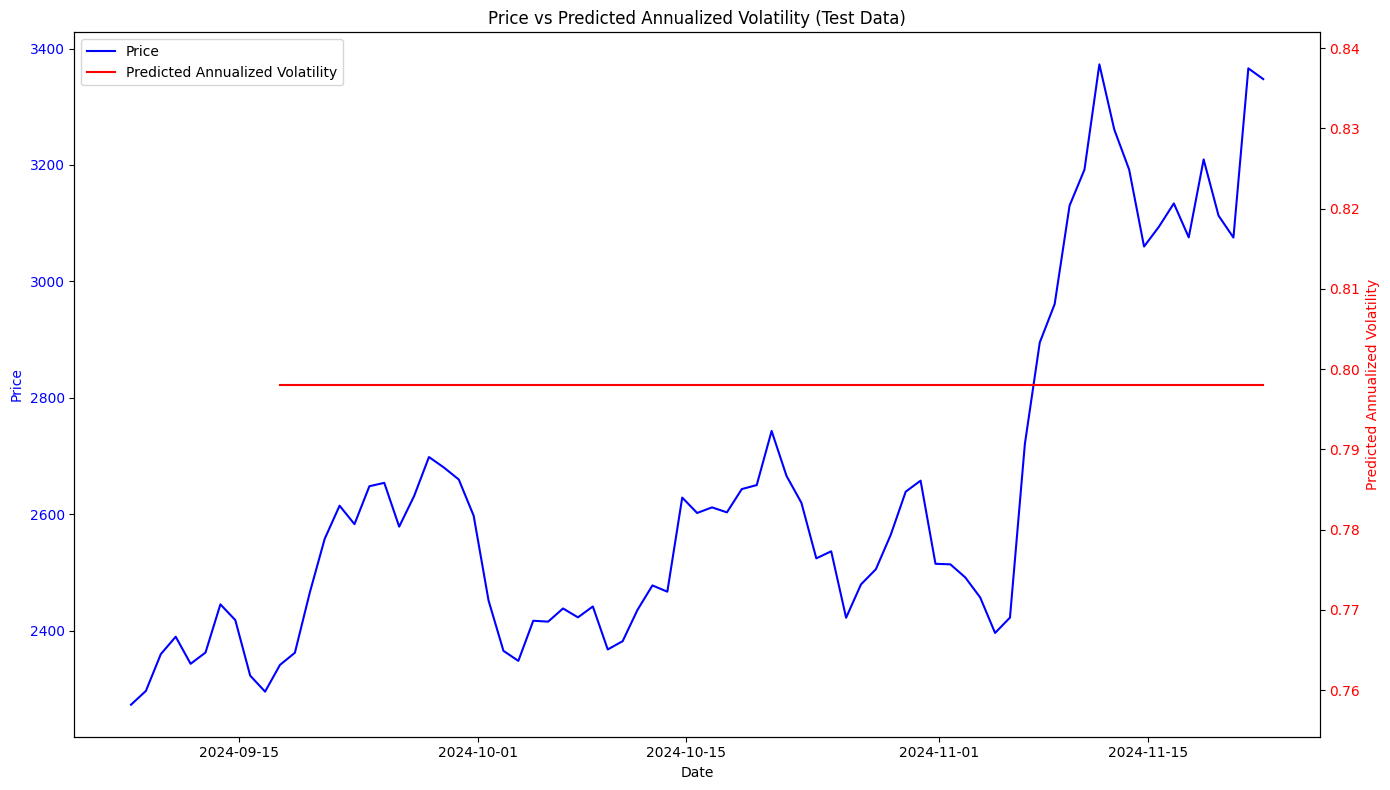

Price Statistics:
count      77.000000
mean     2637.559125
std       294.833299
min      2272.697285
25%      2422.368480
50%      2564.813856
75%      2680.218702
max      3372.791486
dtype: float64

Predicted Annualized Volatility Statistics:
count    6.700000e+01
mean     7.980874e-01
std      1.118602e-16
min      7.980874e-01
25%      7.980874e-01
50%      7.980874e-01
75%      7.980874e-01
max      7.980874e-01
dtype: float64


In [18]:
test_returns = prices_df['log_returns'][((len(prices_df) // 10) * 8):].dropna().values

test_prices = prices_df['c'][((len(prices_df) // 10) * 8):].dropna().values

predicted_variance = evaluate_and_visualize_dgarch(
    trained_dgarch_torch, test_prices, test_returns)



Some notes on the DGARCH model, the alpha and beta values tend to 0 and we get a fixed value of predicted volatility. Including the margin of safety we do approach the values that gauntlet provides for existing lending platforms.